#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [6]:
import pandas as pd
import time
import warnings
import seaborn as sns

from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV

from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, plot_importance

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
warnings.filterwarnings('ignore')

## Подготовка

### Загрузка данных

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])
taxi.sort_index(inplace=True)

In [4]:
taxi.info()
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi = taxi.resample('1H').sum()

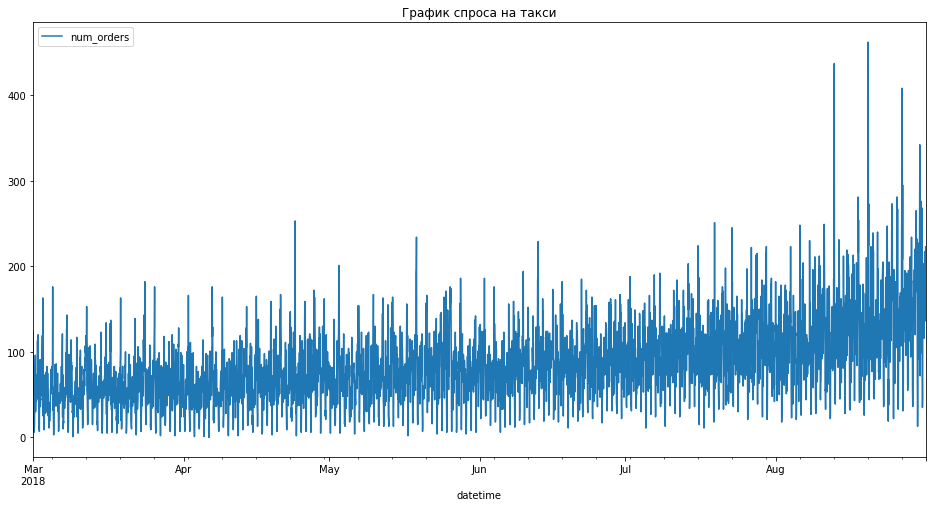

In [6]:
taxi.plot(figsize=(16, 8))
plt.title('График спроса на такси')
plt.show()

### Вывод после загрузки данных

- В загруженом датафрейме 1 столбец - num_orders (целевой признак) и 26495 строк. Данные представлены как временной ряд спроса на такси каждые 10 мин, пропуски отсутсвуют.
- Ресемплировали временной ряд до одного часа.

## Анализ

### Первоначальный анализ

In [7]:
print(f'Начальная дата: {taxi.index.min()}')
print(f'Конечная дата: {taxi.index.max()}')
print(f'Всего времени: {taxi.index.max() - taxi.index.min()}')

Начальная дата: 2018-03-01 00:00:00
Конечная дата: 2018-08-31 23:00:00
Всего времени: 183 days 23:00:00


Данные представлены за пол года (с марта по конец августа).

In [8]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


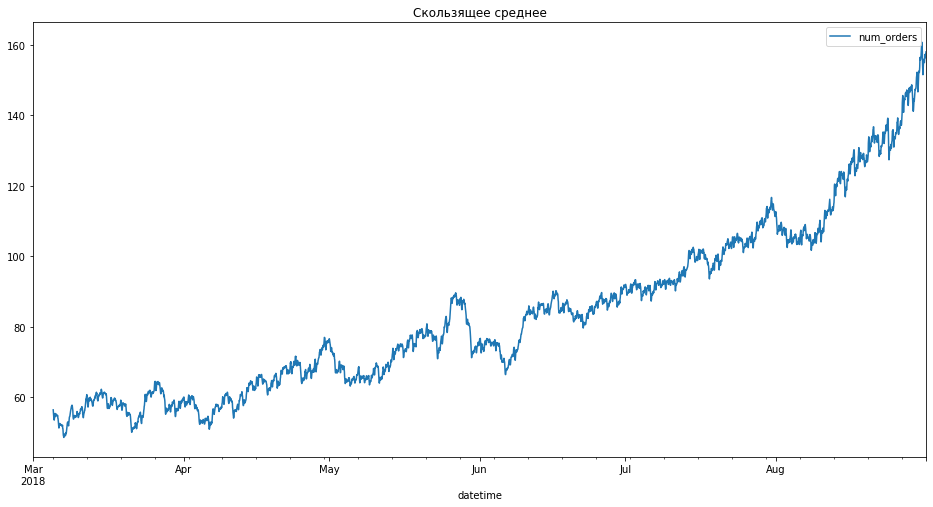

In [9]:
taxi.rolling(100).mean().plot(figsize=(16, 8))
plt.title('Скользящее среднее')
plt.show()

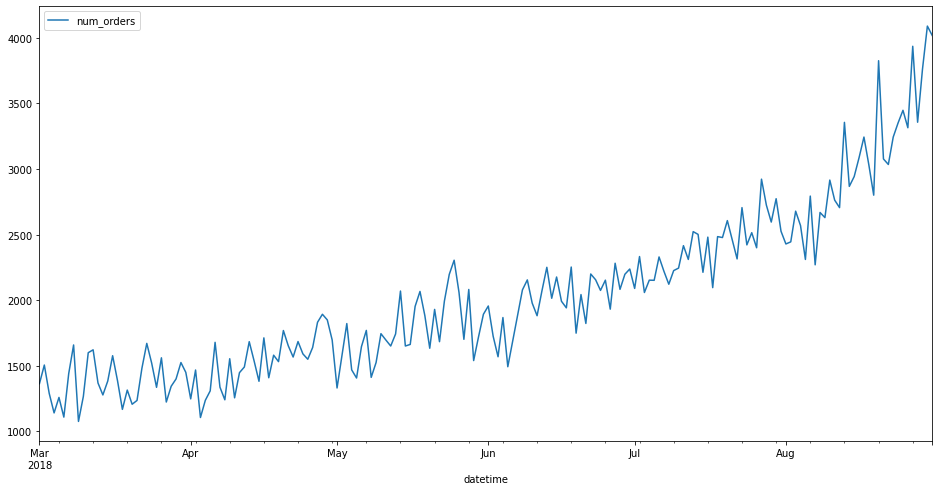

In [10]:
taxi.resample('1D').sum().plot(figsize=(16, 8))
plt.show()

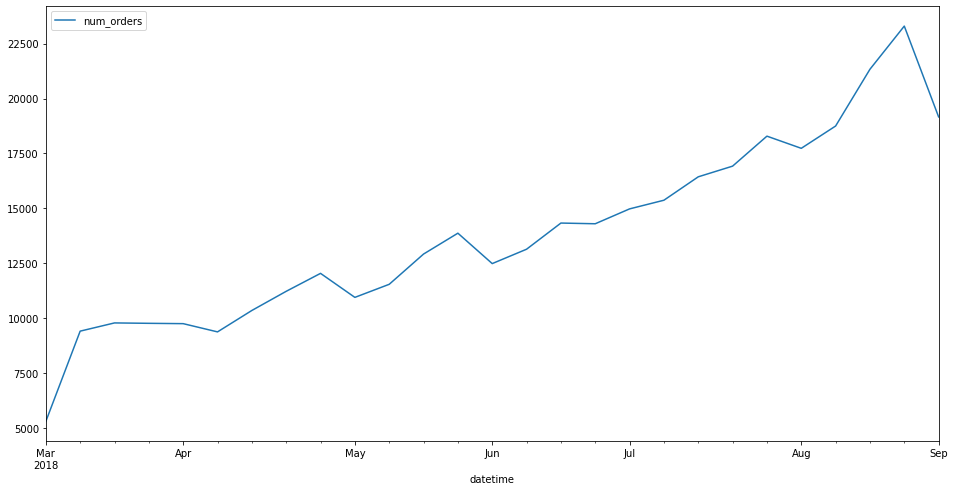

In [11]:
taxi.resample('1W').sum().plot(figsize=(16, 8))
plt.show()

При просмотре графика скользящего среднего и ресемплированых графиков (это по сути одни и те же графики с разной степенью сглажености), виден общий тренд повышения спроса по ходу года. Изучим сезонность...

### Тренд и сезонность

In [12]:
def decomp(df):
    decomposed = seasonal_decompose(df)
    
    plt.figure(figsize=(6, 10))
    
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonal')
    
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    
    plt.tight_layout()
    
    plt.show()

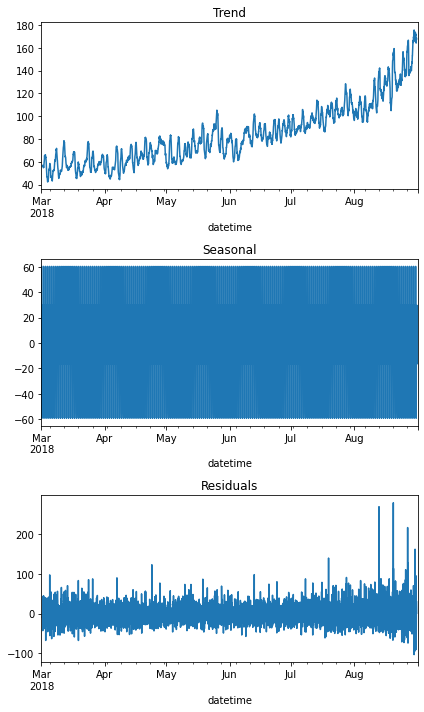

In [13]:
# Декомпозиция временного ряда за пол года
decomp(taxi)

Сезонности за пол года не видно, однако общий тренд тот же, что мы видели на предыдущих графиках, спрос растет. Посмотрим на сезонность в более близком приближении.

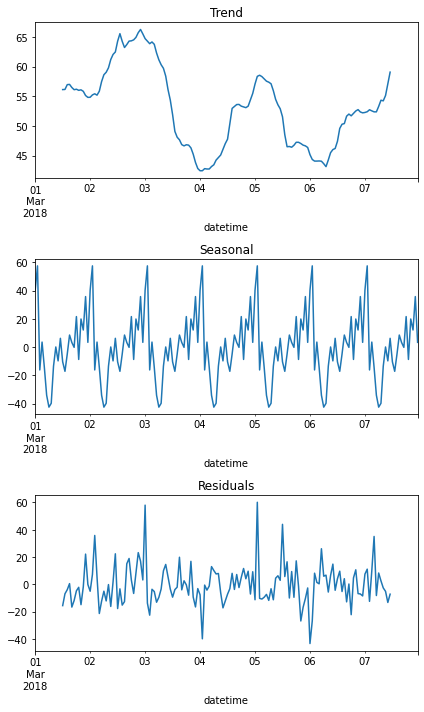

In [14]:
# Декомпозиция временного ряда за неделю
decomp(taxi['2018-03-01': '2018-03-07'])

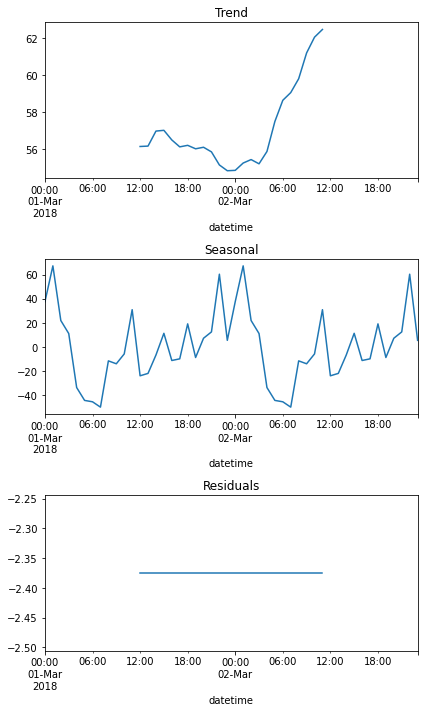

In [15]:
# Декомпозиция временного ряда за 2 дня 
decomp(taxi['2018-03-01': '2018-03-02'])

В таком близком приближении тренд уже не так очевиден, однако теперь видна сезонность: максимальный спрос на такси у нас примерно с 18:00 до 02:00, минимальный спрос в 6:00. Такая тенденция выглядит логично.

### Разность ряда

In [16]:
def mean_std(df, title):
    df_iner = df.copy()
    df_iner['mean'] = df_iner['num_orders'].rolling(20).mean()
    df_iner['std'] = df_iner['num_orders'].rolling(20).std()
    df_iner.plot(figsize=(15, 5), title=title)
    plt.show()

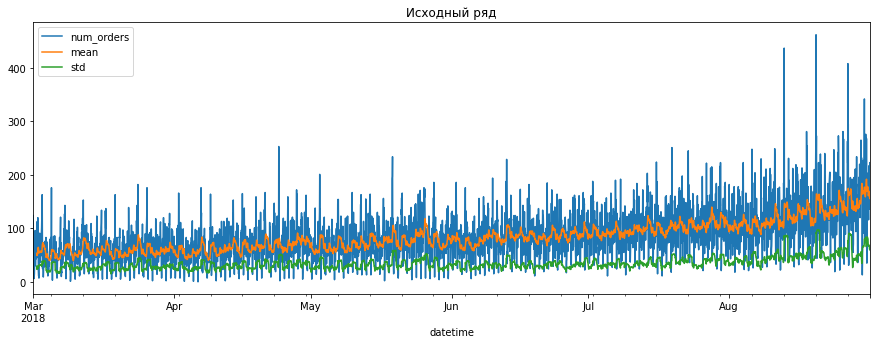

In [17]:
mean_std(taxi, 'Исходный ряд')

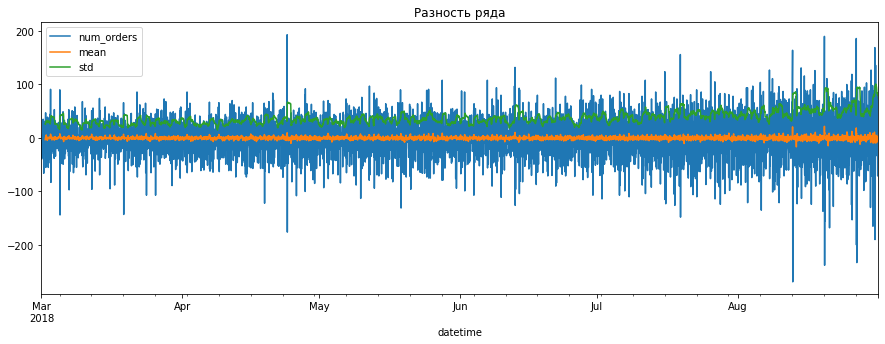

In [18]:
mean_std(taxi-taxi.shift(), 'Разность ряда')

Судя по графику разности ряда к концу исследуемого периода разброс спроса на такси вырос, возможно это проявление годовой сезонности, однако мы не можем ответить на этот вопрос т.к. нам нужны данные за другие года в этот же период.

### Вывод после анализа

**1. Первоначальный анализ**

- Начальная дата: 2018-03-01 00:00:00
- Конечная дата: 2018-08-31 23:00:00
- Всего времени: 183 days 23:00:00
- Данные представлены за пол года (с марта по конец августа).

При просмотре графика скользящего среднего и ресемплированых графиков (это по сути одни и те же графики с разной степенью сглажености), виден общий тренд повышения спроса по ходу года. Изучим сезонность...

**2. Тренд и сезонность**

- Общий тренд по ходу всего исследуемого приода - рост спроса на такси.
- Сезонность - суточная. Максимальный спрос на такси у нас примерно с 18:00 до 02:00, минимальный спрос в 6:00. Такая тенденция выглядит логично.

**3. Разность ряда**

Судя по графику разности ряда к концу исследуемого периода разброс спроса на такси вырос, возможно это проявление годовой сезонности, однако мы не можем ответить на этот вопрос т.к. нам нужны данные за другие годы в этот же период.

## Обучение

### Создание признаков

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    data_for_model = df.copy()
    
    data_for_model['hour'] = data_for_model.index.hour
    data_for_model['dayofweek'] = data_for_model.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_for_model[f'lag_{str(lag)}'] = data_for_model['num_orders'].shift(lag)
        
    data_for_model['rolling_mean'] = data_for_model['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data_for_model = data_for_model.dropna()
    
    return data_for_model

In [20]:
data_for_model = make_features(taxi, 24, 30)

In [21]:
data_for_model.info()
data_for_model.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4386 entries, 2018-03-02 06:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4386 non-null   int64  
 1   hour          4386 non-null   int64  
 2   dayofweek     4386 non-null   int64  
 3   lag_1         4386 non-null   float64
 4   lag_2         4386 non-null   float64
 5   lag_3         4386 non-null   float64
 6   lag_4         4386 non-null   float64
 7   lag_5         4386 non-null   float64
 8   lag_6         4386 non-null   float64
 9   lag_7         4386 non-null   float64
 10  lag_8         4386 non-null   float64
 11  lag_9         4386 non-null   float64
 12  lag_10        4386 non-null   float64
 13  lag_11        4386 non-null   float64
 14  lag_12        4386 non-null   float64
 15  lag_13        4386 non-null   float64
 16  lag_14        4386 non-null   float64
 17  lag_15        4386 non-null

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,6,4,11.0,20.0,64.0,75.0,120.0,90.0,58.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,58.133333
2018-03-02 07:00:00,7,7,4,11.0,11.0,20.0,64.0,75.0,120.0,90.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,54.366667
2018-03-02 08:00:00,46,8,4,7.0,11.0,11.0,20.0,64.0,75.0,120.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,51.766667
2018-03-02 09:00:00,45,9,4,46.0,7.0,11.0,11.0,20.0,64.0,75.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,50.933333
2018-03-02 10:00:00,54,10,4,45.0,46.0,7.0,11.0,11.0,20.0,64.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,50.233333


Исходя из анализа данных, у нас наблюдается суточная сезонность, соотвественно новые входные признаки мы делали с учетом этого знания.

Создали 26 новых признаков:
- Час и номер дня недели.
- 24 сдвига ряда (до 24 часов).
- Скользящее среднее.

### Разделение данных на тренировочную и тестовую

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data_for_model.drop('num_orders', axis=1),
                                                    data_for_model['num_orders'],
                                                    shuffle=False, test_size=0.1)

In [34]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (3947, 27)
X_test: (439, 27)
y_train: (3947,)
y_test: (439,)


### Подготовка функции кросс-валидации и функции качества модели для RandomizedSearchCV

In [24]:
def rmse(y, preds):
    return (mean_squared_error(y, preds))**0.5

rmse_scorer = make_scorer(rmse, greater_is_better = False)

In [25]:
time_series_cv = TimeSeriesSplit(n_splits=4).split(X_train)

- Метрика оценки качетсва модели: RMSE.
- Используем TimeSeriesSplit вместо обычной кросс-валидации, чтобы данные не перемешивались, т.к. порядко данных в данной задаче важен.

### PipeLine

In [26]:
RANDOM_STATE = 1

#Столбцы для масштабирования
num_columns = X_train.columns

# Пайплайн полной подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('num',  StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [27]:
# Словарь для перебора моделей и гиперпараметров к ним

param_grid = [
     #словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__min_samples_split': range(1, 5),
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    
    # словарь для модели CatBoostRegressor 
    {
        'models': [CatBoostRegressor(iterations=100, silent=True)],
        'preprocessor__num': ['passthrough']   
    },
    # словарь для модели LinearRegressor
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    # словарь для LightGBMRegressor
    {
        'models': [LGBMRegressor()],
        'models__num_leaves': range(40, 50),
        'models__max_depth': range(-1, 1),
        'preprocessor': ['passthrough']
    }
]

In [28]:
# Рандомный поиск наиболее качетвенных моделей и параметров к ним
grid = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=time_series_cv, 
    scoring=rmse_scorer,
    n_iter=20,
    n_jobs = -1,
    random_state=RANDOM_STATE
)
search = grid.fit(X_train, y_train)

In [29]:
results = pd.DataFrame(search.cv_results_)

In [30]:
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__max_depth,param_models,param_preprocessor,param_models__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
8,0.960078,0.062987,0.003331,0.000515,passthrough,NaN,NaN,<catboost.core.CatBoostRegressor object at 0x7...,NaN,NaN,"{'preprocessor__num': 'passthrough', 'models':...",-21.513977,-23.761021,-25.151879,-32.353247,-25.695031,4.057353,1
16,2.869927,0.921277,0.028218,0.038336,NaN,NaN,0,LGBMRegressor(),passthrough,46,"{'preprocessor': 'passthrough', 'models__num_l...",-22.839216,-23.428340,-25.253287,-32.921987,-26.110708,4.031949,2
7,2.579035,0.697915,0.048853,0.044762,NaN,NaN,-1,LGBMRegressor(),passthrough,46,"{'preprocessor': 'passthrough', 'models__num_l...",-22.839216,-23.428340,-25.253287,-32.921987,-26.110708,4.031949,2
11,2.819032,0.544401,0.051946,0.041131,NaN,NaN,-1,LGBMRegressor(),passthrough,41,"{'preprocessor': 'passthrough', 'models__num_l...",-22.839216,-23.719539,-25.245914,-32.887273,-26.172985,3.970974,4
10,2.685889,1.080284,0.004641,0.000598,NaN,NaN,0,LGBMRegressor(),passthrough,42,"{'preprocessor': 'passthrough', 'models__num_l...",-22.839216,-23.408529,-25.331062,-33.174922,-26.188432,4.137972,5


In [35]:
best_model = search.best_estimator_['models']

Мы использовали PipeLine и RandomizedSearchCV для поиска наилучшей модели. 
Перебирали 4 модели и их гиперпарметры: 

1. DecisionTreeRegressor
2. CatBoostRegressor
3. LinearRegressor
4. LightGBMRegressor

Также для DecisionTreeRegressor и LinearRegressor использовался StandardScaler для всех данных.

**Лучшей моделью по метрике RMSE оказался CatBoostRegressor**.

### Вывод после обучения

**1. Создание признаков**

Исходя из анализа данных, у нас наблюдается суточная сезонность, соотвественно новые входные признаки мы делали с учетом этого знания.

Создали 26 новых признаков:
- Час и номер дня недели.
- 24 сдвига ряда (до 24 часов).
- Скользящее среднее.

**2. Разделение данных на тренировочную и тестовую**

Размер тренировочных и тестовых данных.

- X_train: (3947, 27)
- X_test: (439, 27)
- y_train: (3947,)
- y_test: (439,)

**3. Подготовка функции кросс-валидации и функции качества модели для RandomizedSearchCV**

- Метрика оценки качетсва модели: RMSE.
- Используем TimeSeriesSplit вместо обычной кросс-валидации, чтобы данные не перемешивались, т.к. порядко данных в данной задаче важен.

**4. PipeLine**

Мы использовали PipeLine и RandomizedSearchCV для поиска наилучшей модели. 
Перебирали 4 модели и их гиперпарметры: 

1. DecisionTreeRegressor
2. CatBoostRegressor
3. LinearRegressor
4. LightGBMRegressor

Также для DecisionTreeRegressor и LinearRegressor использовался StandardScaler для всех данных.

**Лучшей моделью по метрике RMSE оказался CatBoostRegressor**.

## Тестирование

In [32]:
print(f'RMSE лушей модели на тестовых данных: {round(rmse(y_test, best_model.predict(X_test)), 2)}')

RMSE лушей модели на тестовых данных: 40.98


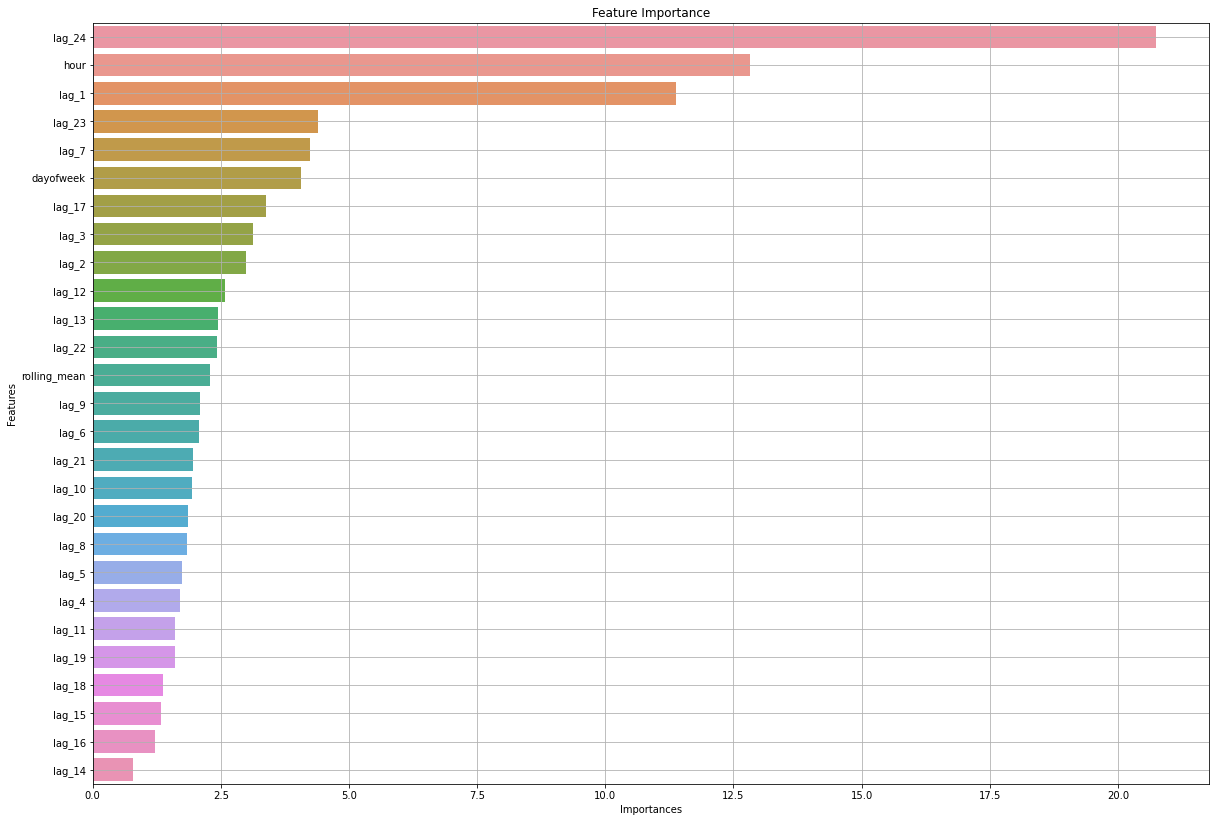

In [33]:
# Извлечение важности признаков
importance = best_model.get_feature_importance(prettified=True)
importance.columns = ['Features', 'Importances']
importance['Features'] = importance['Features'].astype('int')

# Соотнесение названий колонок и признаков
feature_names = X_train.columns.to_list()
importance = importance.sort_values('Features')
for num in range(len(X_train.columns.to_list())):
    importance['Features'] = importance['Features'].replace(num, feature_names[num])

# Сортировка важности признаков
importance = importance.sort_values('Importances', ascending=False)

# Создание графика важности признаков
plt.figure(figsize=(20, 14))
sns.barplot(importance['Importances'], importance['Features'])
plt.title('Feature Importance')
plt.grid(True)
plt.show()

### Вывод после тестирования (ИТОГ)

Лучшая модель (CatBoostRegressor) показалана тестовой выборке RMSE = 40.98, это значение удовлетворяет поставленной задаче (RMSE < 48).

Самыми важными факторами для модели, оказались признаки (топ-3): lag-24, hour, lag-1. Это выглядит логично: больше всего на спрос влияет значение спроса ровно 24 часа назад, т.е. какой спрос был в это же время вчера. Далее идет час, тоже ничего неожиданного, на этапе анализа данных была очень отчетливо видна суточная сезонность. Ну и спрос час назад, тоже не удивительно, ведь обычно спрос инертен (в масштабе в 1 час конкретно в данной задаче). Редко бывает такое, что сейчас высокий спрос, а через час он нулевой, скорее он будет снижаться достаточно плавно.